In [1]:
##IMPORT REQUIRED PYTHON LIBRARIES

##Import data and graph tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

##Import data science models
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.forecasting.theta import ThetaModel
from prophet import Prophet
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from xgboost import XGBRegressor

##Import metrics to measure each model's performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
##LOAD CLEAN DATA

#This defines the dataframe (df) and will use the Pandas function 'read_excel' to access the data in the .XLS File
df = pd.read_excel(r'C:\Users\danhe\OneDrive\Data Science BSC\Professional Practice\Projects\Idea 1 - Cannabis Legislisation in Canada\Canada GDP\Canada GDP - CLEAN.xlsx', sheet_name='Sheet1', skiprows=0)

print(df.columns.tolist()) #CHECK THE COLUMN HEADERS - IMPORTANT FOR REST OF SCRIPT THAT THEY MATCH THE years and NAICS definitions

['NAICS', 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]


In [3]:
##PERFORM DATA CLEANSING TASKS
#Set NAICS as Index Column
df = df.set_index('NAICS')

#Transpose years from columns to rows
df_clean = df.transpose()

#Deal with commas
df_clean = df_clean.replace({',': ''}, regex=True).astype(float)

#Convert years to datetime
df_clean.index = pd.to_datetime(df_clean.index, format ='%Y')

#Define frequency as Year Start
df.index.freq = 'AS'

#Manage missing values
df_clean = df_clean.apply(pd.to_numeric, errors='coerce').ffill()

#Return all valid column names for NAICS
print("Cleaned Columns (Industries):")
print(df_clean.columns.tolist())

Cleaned Columns (Industries):
['All industries', 'Goods-producing industries', 'Service-producing industries', 'Business sector industries', 'Non-business sector industries', 'Industrial production', 'Non-durable manufacturing industries', 'Durable manufacturing industries', 'Information and communication technology sector', 'Energy sector', 'Industrial production (1950 definition)', 'Public Sector', 'Content and media sector', 'All industries (except cannabis sector)', 'Cannabis sector', 'All industries (except unlicensed cannabis sector)', 'Agriculture, forestry, fishing and hunting', 'Mining, quarrying, and oil and gas extraction', 'Utilities', 'Construction', 'Manufacturing', 'Wholesale trade', 'year', 'Transportation and warehousing', 'Information and cultural industries', 'Finance and insurance', 'Real estate and rental and leasing', 'Professional, scientific and technical services', 'Management of companies and enterprises', 'Administrative and support, waste management and reme

In [4]:
##SELECT GDP INDUSTRY FOR PERFORMANCE RANKING
##CHANGE TARGET_INDUSTRY SELECTION TO ANY OF THE NAICS CATEGORIES ABOVE TO CHANGE CATEGORY BEING TESTED

target_industry = "Cannabis sector"
y = df_clean[target_industry]
print(f"Target select: {target_industry}")

Target select: Cannabis sector


In [5]:
##TEST AND TRAIN SPLIT

#Define the number of years to be used for testing 
test_years = 4

#Split the data
train_data = df_clean[target_industry].iloc[:-test_years]
test_data = df_clean[target_industry].iloc[-test_years:]

#Prophet requires seperate coding as requires the dataframe to be in a specific format
train_prophet = train_data.reset_index().rename(columns={'index': 'ds', target_industry: 'y'})
test_prophet = test_data.reset_index().rename(columns={'index': 'ds', target_industry: 'y'})

#Adding XGBoost features 
def create_time_features(series):
    df_feat = pd.DataFrame(series)
    df_feat['Year'] = df_feat.index.year
    return df_feat[['Year']], df_feat.iloc[:, 0]

X_train, y_train_xgb = create_time_features(train_data)
X_test, y_test_xgb = create_time_features(test_data)
print ("XGBoost features created using 'Year' as the predictor")

#Print shapes of datasets as a check
print(f"Full dataset shape: {df_clean.shape}")
print(f"Training set: {train_data.index.min().year} to {train_data.index.max().year}")
print(f"Testing set: {test_data.index.min().year} to {test_data.index.max().year}")

XGBoost features created using 'Year' as the predictor
Full dataset shape: (9, 36)
Training set: 2017 to 2021
Testing set: 2022 to 2025


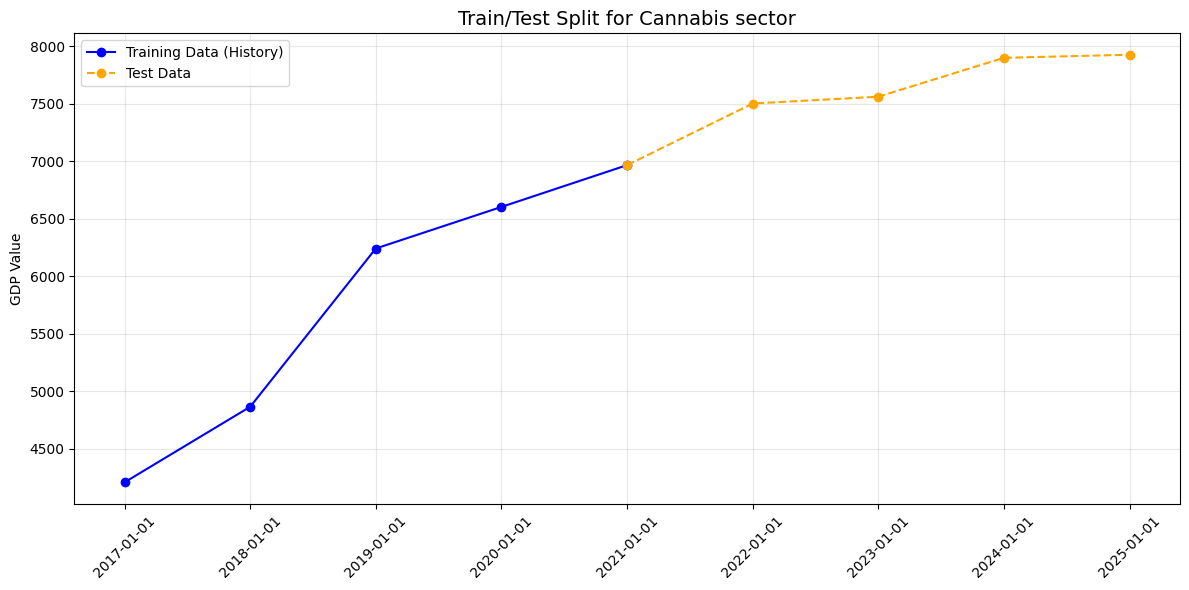

In [6]:
##DRAW GRAPHS TO VISUALISE SPLITS AS FURTHER CHECKER

plt.figure(figsize=(12, 6))
plt.plot(train_data, label='Training Data (History)', color='blue', marker='o')

last_train_point = train_data.tail(1) ##Add in 'stitch' to piece together both series as single line
connected_test = pd.concat([last_train_point, test_data])
plt.plot(connected_test.index, connected_test, label='Test Data', color='orange', marker='o', linestyle='--')

plt.title(f'Train/Test Split for {target_industry}', fontsize=14)
plt.ylabel('GDP Value')
plt.legend()
plt.grid(True, alpha=0.3)

plt.xticks(df_clean.index, rotation=45)
plt.tight_layout()
plt.show()

In [7]:
##MODEL TESTINGS

#Create storage for results
results = {}

#EXPONENTIAL SMOOTHING  #es_model is the Exponential Smoothing model, es_pred is the prediction model
es_model = ExponentialSmoothing(train_data, trend='add', seasonal=None).fit()
es_pred = es_model.forecast(test_years)
results['Exponential_Smoothing'] = es_pred

#PROPHET
m = Prophet(yearly_seasonality=True) ##CONSIDER CHANGING THIS AS YEARLY FIGURES SO NO SEASONALITY?
m.fit(train_prophet)
future = m.make_future_dataframe(periods = test_years, freq='AS')
forecast = m.predict(future)
prophet_pred = forecast['yhat'].iloc[-test_years:].values
results['Prophet'] = prophet_pred

#SARIMA
sarima_model = SARIMAX(train_data, order=(1, 1, 1)).fit(disp=False)
sarima_pred = sarima_model.forecast(test_years)
results['SARIMA'] = sarima_pred

#THETA
theta_model = ThetaModel(train_data).fit()
theta_pred = theta_model.forecast(test_years)
results['Theta'] = theta_pred

#XGBoost
xgb_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, objective='reg:squarederror')
xgb_model.fit(X_train, y_train_xgb)

xgb_pred = xgb_model.predict(X_test)
results['XGBoost'] = xgb_pred

print("Model Testing complete!")

C:\Data Science Projects\Cannabis and Canada\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
13:07:16 - cmdstanpy - INFO - Chain [1] start processing
13:07:16 - cmdstanpy - INFO - Chain [1] done processing
C:\Data Science Projects\Cannabis and Canada\.venv\Lib\site-packages\prophet\forecaster.py:1872: FutureWarning: 'AS' is deprecated and will be removed in a future version, please use 'YS' instead.
  dates = pd.date_range(
C:\Data Science Projects\Cannabis and Canada\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)
C:\Data Science Projects\Cannabis and Canada\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN wil

Model Testing complete!


In [15]:
##CALCULATE RESULTS OF MODEL TESTING

#Create storage
performance_metrics = []

#Define measures and model names
for model_name, prediction in results.items():
    actuals = test_data.values
    preds = np.array(prediction)
    mae = mean_absolute_error(test_data, prediction)
    rmse = np.sqrt(mean_squared_error(test_data, prediction))

#Calculate MAPE
    mape = np.mean(np.abs((actuals - preds) / (actuals + 1e-10))) * 100
    
#Take key information and round to 2 decimal places
    performance_metrics.append({
        'Model': model_name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE %': round(mape, 2)
    })

#Convert to a dataframe, sort by RMSE (lower RMSE is better)
ranking_df = pd.DataFrame(performance_metrics).sort_values(by='RMSE')
print("\n--- FINAL MODEL RANKING ---")
print(ranking_df)


--- FINAL MODEL RANKING ---
                   Model      MAE     RMSE  MAPE %
3                  Theta   237.30   279.14    3.05
2                 SARIMA   276.85   318.45    3.55
4                XGBoost   755.01   779.01    9.72
1                Prophet  1254.35  1374.44   16.09
0  Exponential_Smoothing  1317.60  1462.13   16.89
2022-01-01     7951.400134
2023-01-01     8676.200090
2024-01-01     9401.000046
2025-01-01    10125.800001
Freq: YS-JAN, dtype: float64


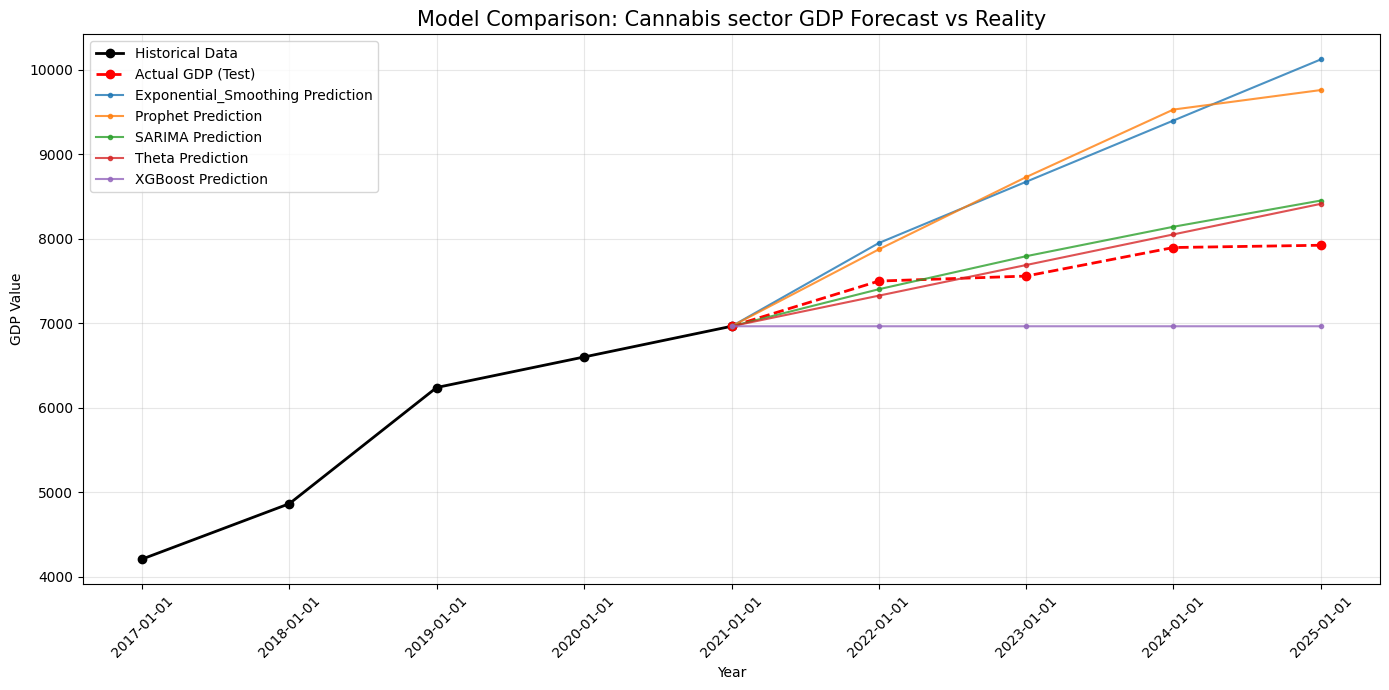

In [12]:
## SHOW RESULTS OF MODEL TESTING (STITCHED FOR CONTINUITY)

plt.figure(figsize=(14, 7))

# 1. Plot the Historical "Training" Data
plt.plot(train_data.index, train_data, label='Historical Data', color='black', linewidth=2, marker='o')

# 2. Get the last point of training to "stitch" the lines together
last_date = train_data.index[-1:]
last_val = train_data.iloc[-1:]

# 3. Plot the Actual "Test" Data (The Ground Truth) - Stitched
connected_actuals = pd.concat([last_val, test_data])
plt.plot(connected_actuals.index, connected_actuals, label='Actual GDP (Test)', 
         color='red', linestyle='--', linewidth=2, marker='o')

# 4. Plot each model's prediction - Stitched
for model_name, prediction in results.items():
    # Convert prediction to a Series with the correct date index if it isn't already
    pred_series = pd.Series(np.array(prediction).flatten(), index=test_data.index)
    
    # Stitch the last training point to the prediction
    stitched_pred = pd.concat([last_val, pred_series])
    
    plt.plot(stitched_pred.index, stitched_pred, label=f'{model_name} Prediction', alpha=0.8, marker='.')

# Formatting
plt.title(f'Model Comparison: {target_industry} GDP Forecast vs Reality', fontsize=15)
plt.xlabel('Year')
plt.ylabel('GDP Value')
plt.xticks(df_clean.index, rotation=45) # Ensure every year is labeled
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight', transparent=True)

plt.show()